# Customer segmentation with k-means clustering

## Introduction

### Customer segmentation

*Customer segmentation* is the process of dividing customers into groups based on common characteristics, which allows companies market each group effectively and appropriately. Segmentation helps marketers to better tailor their marketing efforts to various audience subsets, which can relate to both communications and product development.

### Data

For this analysis I am using a public dataset from UCI Machine Learning Repositiry, which can found [here](http://archive.ics.uci.edu/ml/index.php). This dataset contains information on transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Attribute information:**

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal
* Quantity: The quantities of each product (item) per transaction. Numeric
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated
* UnitPrice: Unit price. Numeric, Product price per unit in sterling
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer
* Country: Country name. Nominal, the name of the country where each customer resides.

## Data wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('online_retail_dataset.xlsx', sheet_name='Online Retail')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


*Description* and *CustomerID* columns have NULL values

In [5]:
df.shape

(541909, 8)

<a id='eda'></a>
## Exploratory data analysis (EDA)

Let us have a look at the data and decide whether we need any data cleaning and data transformation for further analysis.

### NULL values

In [6]:
print('Number of missing values in the dataset:', df.isnull().sum().sum())
print('Percentage of missing values in the dataset:', df.isnull().sum().sum()*100/(df.shape[0]*df.shape[1]))

Number of missing values in the dataset: 136534
Percentage of missing values in the dataset: 3.149375633178264


In [7]:
print("Number of missing values in 'Description' column:", df['Description'].isnull().sum())
print("Percentage of missing values in 'Description' column:", df['Description'].isnull().sum()*100/df.shape[0])

Number of missing values in 'Description' column: 1454
Percentage of missing values in 'Description' column: 0.2683107311375157


In [8]:
print("Number of missing values in 'CustomerID' column:", df['CustomerID'].isnull().sum())
print("Percentage of missing values in 'CustomerID' column:", df['CustomerID'].isnull().sum()*100/df.shape[0])

Number of missing values in 'CustomerID' column: 135080
Percentage of missing values in 'CustomerID' column: 24.926694334288598


About 25% of CustomerIDs is missing

### Number of unique customers

In [9]:
df['CustomerID'].nunique()

4372

### Number of purchases

In [10]:
df['InvoiceNo'].nunique()

25900

### Period of time

In [11]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

### Country

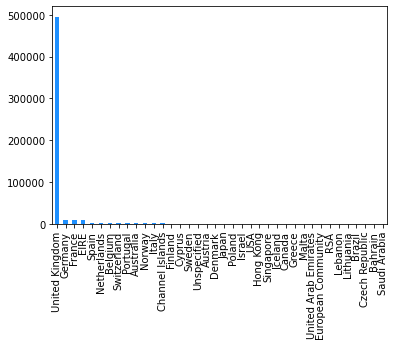

In [12]:
df['Country'].value_counts().plot.bar(color='dodgerblue');

In [13]:
df['Country'].nunique()

38

So we have approximately 1 year data record of 25,900 purchases for 4,372 unique users made in 38 countries (mostly in the UK)

### Quantity and unit price of the products

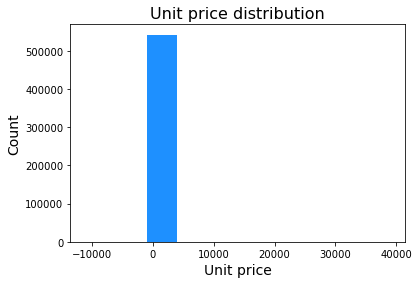

In [14]:
# Let's look at the price distribution of the products

plt.hist(data=df, x='UnitPrice', color='dodgerblue')
plt.xlabel('Unit price', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Unit price distribution", fontsize=16);

It seems that we have negative values and some outliers representing very expensive products. The negative values may be associated with cancelled or refunded orders. Let's remove negative records and outliers and look at the price distribution.

In [16]:
df['UnitPrice'].describe(percentiles=[.99])

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
50%           2.080000
99%          18.000000
max       38970.000000
Name: UnitPrice, dtype: float64

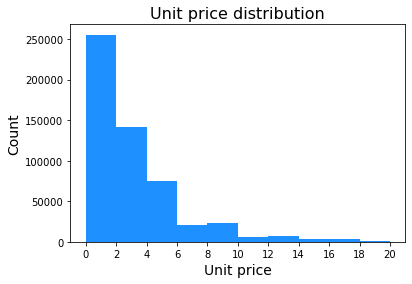

In [17]:
bins = np.arange(0, 21, 2)
ticks = np.arange(0, 21, 2)
plt.hist(data=df, x='UnitPrice', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('Unit price', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Unit price distribution', fontsize=16);

The price for most of the products is equal or less than 10£

Let's look at the negative values in *UnitPrice*

In [18]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


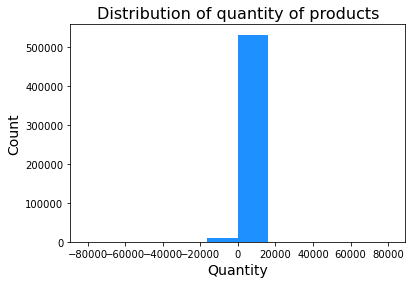

In [19]:
# Let's look at the quantity of the products

plt.hist(data=df, x='Quantity', color='dodgerblue')
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of quantity of products", fontsize=16);

In [20]:
df['Quantity'].describe(percentiles=[.99])

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
50%           3.000000
99%         100.000000
max       80995.000000
Name: Quantity, dtype: float64

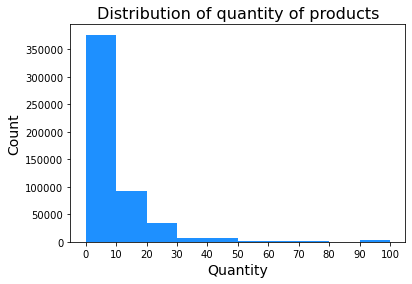

In [21]:
bins = np.arange(0, 110, 10)
ticks = np.arange(0, 110, 10)
plt.hist(data=df, x='Quantity', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of quantity of products', fontsize=16);

In most cases customers buy less than 50 items per order.

Let's look at the negative values in *Quantity*

In [24]:
neg_quantity = df[df['Quantity']<0]

In [25]:
neg_quantity.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


In [26]:
neg_quantity.shape

(10624, 8)

In [27]:
print("The percentage of records with negative Quantity:", neg_quantity.shape[0]*100/df.shape[0])

The percentage of records with negative Quantity: 1.9604767590130445


There are 10,624 raws with negative *Quantity* values, which is about 2% out of the total number of records in the dataframe.

## Data cleaning and transformation

### Drop NULL values

We have NULL records in columns *CustomerId* and *Description*. Because we are planning to predict CLTV, we need records for each customer ID to proceed calculations. Let's drop rows containing NULL values.

In [28]:
df.dropna(subset=['CustomerID'], inplace=True)

In [29]:
df.shape

(406829, 8)

In [30]:
# Let's check NULL records in the CustomerId column
df['CustomerID'].isnull().sum()

0

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


### Handle negative quantity

In [32]:
df = df.loc[df['Quantity'] > 0]

In [33]:
# Let's check negative records
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### Remove rows with negative price

In [34]:
df = df.loc[df['UnitPrice'] > 0]

In [35]:
# Let's check negative records
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### Handle incomplete data

In [36]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [37]:
# Let's check the time period
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-11-30 17:37:00'))

### Calculate total sales

Let us create a column for the total sales value for each transaction

In [38]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

### Create per-customer data

Let us transform our data and prepare the purchase history for each individual customer.

In [39]:
df_customers = df.groupby('CustomerID').agg({'Sales': sum, 'InvoiceNo': lambda x: x.nunique()})

In [41]:
df_customers.columns = ['TotalSales', 'OrderCount']

In [42]:
df_customers['AvgOrderValue'] = df_customers['TotalSales'] / df_customers['OrderCount']

In [46]:
df_customers.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


### Normalize data

Clustering algorithms are highly affected by the scales of the data, so we need to normalize this data to be on the same scale.

In [47]:
# Rank the data
df_rank = df_customers.rank(method='first')

In [48]:
df_rank.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4289.0,1.0,4297.0
12347.0,3957.0,3469.0,3887.0
12348.0,3349.0,2860.0,3302.0
12349.0,3320.0,2.0,4237.0
12350.0,1240.0,3.0,2560.0


In [49]:
# Let us normalize the data to center around the mean and have a mean of 0 and a standard deviation of 1
df_normalized = (df_rank - df_rank.mean()) / df_rank.std()

In [50]:
df_normalized.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724998,-1.731446,1.731446
12347.0,1.457381,1.064017,1.400956
12348.0,0.967288,0.573118,0.929403
12349.0,0.943912,-1.730640,1.683082
12350.0,-0.732721,-1.729834,0.331296


In [51]:
df_normalized.describe()

,TotalSales,OrderCount,AvgOrderValue
count,4.297000e+03,4297.000000,4297.000000
mean,-6.614315e-18,0.000000,0.000000
std,1.000000e+00,1.000000,1.000000
min,-1.731446e+00,-1.731446,-1.731446
25%,-8.657231e-01,-0.865723,-0.865723
50%,0.000000e+00,0.000000,0.000000
75%,8.657231e-01,0.865723,0.865723
max,1.731446e+00,1.731446,1.731446


Now you can see that the values are centered around 0 and have a standard deviation of 1. Let's use this data for our clustering analysis.

## k-means clustering

**k-means clustering** is one of the simplest and commonly used algorithms. It tries to find cluster centers that are representative of certain regions of the data. The algorithm contains two steps: 
   1) assigning each data point to the closest cluster center
   
   2) setting each cluster center as the mean of the data points that are assigned to it.
   
k-means clustering finishes culculations once the assignment of instances to clusters no longer changes.

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics 
from scipy.spatial.distance import cdist

### Define the number of clusters

One downside of using k-means clustering for customer segmentation is that you have to know the number of clusters beforehand. Let us explore two ways of defining the number of clusters in the dataset:
* Silhouette coefficient
* Elbow curve

#### Silhouette coefficient

**Formula for the Silhouette coefficient**: *S = (b - a)/max(a, b)*

where *b* is the average of the distance between a point and its closest cluster, *a* is the average distance among data points within the same cluster. Sillhouette coefficient ranges from -1 to 1, where the closer the values are to 1, the better they are.

In [59]:
for n_cluster in [2, 3, 4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_cluster, max_iter=400, n_init=20).fit(df_normalized[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    silhouette_avg = silhouette_score(df_normalized[['TotalSales', 'OrderCount', 'AvgOrderValue']],
                                      kmeans.labels_) 
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster, silhouette_avg))

Silhouette coefficient for 2 clusters: 0.429
Silhouette coefficient for 3 clusters: 0.413
Silhouette coefficient for 4 clusters: 0.411
Silhouette coefficient for 5 clusters: 0.378
Silhouette coefficient for 6 clusters: 0.378
Silhouette coefficient for 7 clusters: 0.391
Silhouette coefficient for 8 clusters: 0.381


#### Elbow curve

I'm planning to apply **Elbow method** to determine the optimal number of clusters. I will calculate distortion and inertia metrics to identify the number of clusters for customers dataset.

* **Distortion** is calculated as the average of the squared distances from the cluster centers of the respective clusters (the Euclidean distance metric is used)
* **Inertia** is the sum of squared distances of samples to their closest cluster center.

In [61]:
# Calculate inertias and distortions for customers dataset
# Link to original code: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = [] 
inertias = []
K=range(1, 11)

for k in K: 
    kmeanModel = KMeans(n_clusters=k, max_iter=400, n_init=20).fit(df_normalized[['TotalSales',
                                                                                  'OrderCount',
                                                                                  'AvgOrderValue']]) 
    kmeanModel.fit(df_normalized[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    distortions.append(sum(np.min(cdist(df_normalized[['TotalSales',
                                                       'OrderCount',
                                                       'AvgOrderValue']],
                                        kmeanModel.cluster_centers_,
                                        'euclidean'),axis=1)) / df_normalized[['TotalSales',
                                                                               'OrderCount',
                                                                               'AvgOrderValue']].shape[0]) 
    inertias.append(kmeanModel.inertia_)

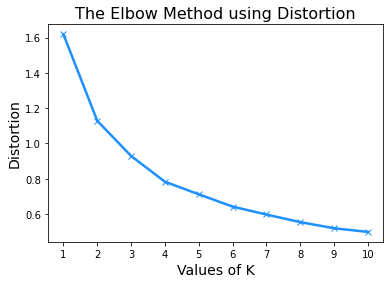

In [62]:
# Plot distortions
plt.plot(K, distortions, 'bx-',  linewidth=2.5, color='dodgerblue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Distortion', fontsize=14) 
plt.title('The Elbow Method using Distortion', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

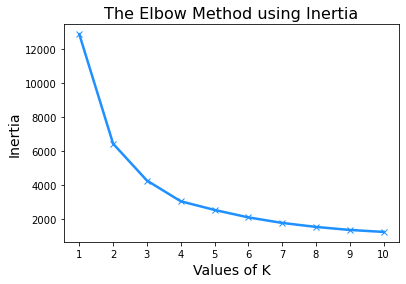

In [63]:
# Plot inertias
plt.plot(K, inertias, 'bx-', linewidth=2.5, color='dodgerblue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Inertia', fontsize=14) 
plt.title('The Elbow Method using Inertia', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

Looking at the Elbow curves and Silhouette coefficient, I will choose number of clusters=4.

### Build k-means clustering model

In [65]:
kmeans = KMeans(n_clusters=4, max_iter=400, n_init=20).fit(df_normalized[['TotalSales', 'OrderCount', 'AvgOrderValue']])

In [66]:
kmeans.labels_

array([3, 0, 0, ..., 1, 2, 0], dtype=int32)

In [97]:
cluster_centres = kmeans.cluster_centers_

In [98]:
cluster_centres

array([[ 1.20749405,  1.00271104,  0.87884198],
       [-1.22763726, -0.77960146, -1.04784395],
       [ 0.25251705,  0.74825236, -0.63856328],
       [-0.1289308 , -0.84714397,  0.80040308]])

In [99]:
df_cluster_centres = pd.DataFrame(cluster_centres, columns=['TotalSales', 'OrderCount', 'AvgOrderValue'])

In [102]:
df_cluster_centres['Cluster'] = df_cluster_centres.index

In [103]:
df_cluster_centres

,TotalSales,OrderCount,AvgOrderValue,Cluster
0,1.207494,1.002711,0.878842,0
1,-1.227637,-0.779601,-1.047844,1
2,0.252517,0.748252,-0.638563,2
3,-0.128931,-0.847144,0.800403,3


It seems that cluster #0 has the highest value for the company, while cluster #1 has the lowest numbers for all three attributes.

In [68]:
df_four_clusters = df_normalized[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
df_four_clusters['Cluster'] = kmeans.labels_

In [69]:
df_four_clusters.head()

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724998,-1.731446,1.731446,3
12347.0,1.457381,1.064017,1.400956,0
12348.0,0.967288,0.573118,0.929403,0
12349.0,0.943912,-1.730640,1.683082,3
12350.0,-0.732721,-1.729834,0.331296,3


In [70]:
df_four_clusters['Cluster'].value_counts()

1    1176
0    1124
3    1065
2     932
Name: Cluster, dtype: int64

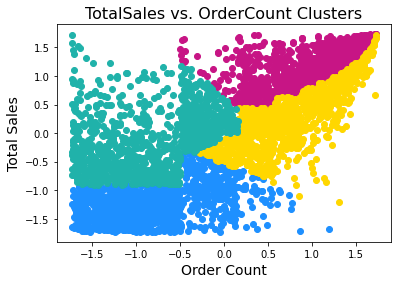

In [95]:
plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['TotalSales'],
            c='mediumvioletred')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['TotalSales'],
            c='dodgerblue')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['TotalSales'],
            c='gold')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['TotalSales'],
            c='lightseagreen')

plt.title('TotalSales vs. OrderCount Clusters', fontsize=16)
plt.xlabel('Order Count', fontsize=14)
plt.ylabel('Total Sales', fontsize=14);

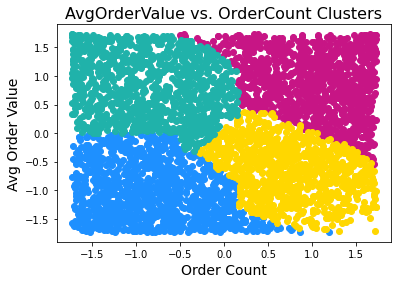

In [96]:
plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['AvgOrderValue'],
            c='mediumvioletred')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['AvgOrderValue'],
            c='dodgerblue')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['AvgOrderValue'],
            c='gold')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['AvgOrderValue'],
            c='lightseagreen')

plt.title('AvgOrderValue vs. OrderCount Clusters', fontsize=16)
plt.xlabel('Order Count', fontsize=14)
plt.ylabel('Avg Order Value', fontsize=14);

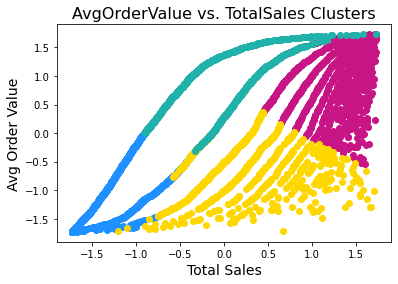

In [94]:
plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['TotalSales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['AvgOrderValue'],
            c='mediumvioletred')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['TotalSales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['AvgOrderValue'],
            c='dodgerblue')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['TotalSales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['AvgOrderValue'],
            c='gold')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['TotalSales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['AvgOrderValue'],
            c='lightseagreen')

plt.title('AvgOrderValue vs. TotalSales Clusters', fontsize=16)
plt.xlabel('Total Sales', fontsize=14)
plt.ylabel('Avg Order Value', fontsize=14);

In [90]:
high_value_cluster = df_four_clusters.loc[df_four_clusters['Cluster'] == 0]
high_value_cluster.head()

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12347.0,1.457381,1.064017,1.400956,0
12348.0,0.967288,0.573118,0.929403,0
12352.0,1.192989,1.309064,0.169275,0
12356.0,1.268760,0.157990,1.557334,0
12359.0,1.585547,0.573924,1.672603,0


In [91]:
df_customers.loc[high_value_cluster.index].describe()

,TotalSales,OrderCount,AvgOrderValue
count,1124.000000,1124.000000,1124.000000
mean,5647.650099,8.477758,619.202388
std,15531.009109,10.538335,769.355703
min,1019.520000,1.000000,215.450606
25%,1768.557500,4.000000,357.351000
50%,2740.800000,6.000000,443.350833
75%,4493.360000,10.000000,619.741909
max,268478.000000,192.000000,14844.766667


Let's look at the most popular purchases by the high value cluster.

In [93]:
pd.DataFrame(
    df.loc[df['CustomerID'].isin(high_value_cluster.index)
          ].groupby('Description').count()['StockCode'].sort_values(ascending=False).head(10))

,StockCode
Description,
JUMBO BAG RED RETROSPOT,1128
REGENCY CAKESTAND 3 TIER,1073
WHITE HANGING HEART T-LIGHT HOLDER,1060
LUNCH BAG RED RETROSPOT,922
PARTY BUNTING,857
ASSORTED COLOUR BIRD ORNAMENT,816
SET OF 3 CAKE TINS PANTRY DESIGN,723
POSTAGE,695
PACK OF 72 RETROSPOT CAKE CASES,682


## Summary

* We applied k-means clustering to understand the difference between segments of an online retail shop
* Using Elbow method and Silhouette coefficient we found the optimal number of segments, which is 4
* We looked at the most popular items bought by the group of high-value customers, which may help to sell the same/similar items to this high-value group and increase conversion.

## References

1. Hwang, Y. H. (2019). Hands-on data science for marketing: Improve your marketing strategies with machine learning using Python and R. Birmingham, UK: Packt Publishing.
2. Müller, A. C., &amp; Guido, S. (2018). Introduction to machine learning with Python: A guide for data scientists. Sebastopol, CA: O'Reilly Media.
3. Customer segmentation definition - what is customer segmentation. (n.d.). Retrieved February 10, 2021, from https://www.shopify.com/encyclopedia/customer-segmentation